# Introducción a  TensorFlow y uso de Eager

**Profesor:** Roberto Muñoz <br />
**E-mail:** <rmunoz@metricarts.com> <br />

**Colaborador:** Sebastián Arpón <br />
**E-mail:** <sarpon@metricarts.com> <br />

**Referencias:** https://www.tensorflow.org/get_started/eager

Eager Execution 
TensorFlow's es un ambiente que evalúa las instrucciones inmediatamente en vez de construir un grafo para que sea evaluado más adelante. Esta ejecución es una plataforma flexible para investigación y experimentación proveyendo una interface interactiva que permite trabajar con estructuras de Python.


In [ ]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

Descargando la data para entrenar usando **the tf.keras.utils.get_file**. Esta función retorna la dirección del archivo descargado.

In [ ]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

In [ ]:
train_dataset_fp

In [ ]:
!head -n5 {train_dataset_fp}

Dado que nuestro data set está en formato CSV. Por tanto trasformaremos el conjunto de atributos y etiquetas a un formato que el modelo de Python pueda usar. Cada fila en el csv será pasada por la función parse_csv la cual toma las primeras 4 columnas de atributos y las transforma en un solo tensor. Luego la última es transformada en una columna de etiqueta, así la función entrega un tensor para etiquetas y otro para atributos.

- sepal length (cm)
- sepal width (cm)
- petal length (cm)
- petal width (cm)

Respecto a las etiquetas

- 0: Iris setosa
- 1: Iris versicolor
- 2: Iris virginica

In [ ]:
def parse_csv(line):
  example_defaults = [[0.], [0.], [0.], [0.], [0]]  # sets field types
  parsed_line = tf.decode_csv(line, example_defaults)
  # First 4 fields are features, combine into single tensor
  features = tf.reshape(parsed_line[:-1], shape=(4,))
  # Last field is the label
  label = tf.reshape(parsed_line[-1], shape=())
  return features, label

Esta celda usa **tf.data.TextLineDataset** para cargar el archivo en formato CSV y transformarlo con nuestra función parse_csv.
Los entrenamientos funcionan mejor cuando están ordenados en forma aleatoria, para esto utilizaremos **tf.data.Dataset.shuffle**
en donde tenemos que fijar el buffer_size a un número más grande que el número de datos que tenemos (120). Para entrenar el modelo más rápido usaremos un tamaño de batch de 32

In [ ]:
train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1)             # skip the first header row
train_dataset = train_dataset.map(parse_csv)      # parse each row
train_dataset = train_dataset.shuffle(buffer_size=1000)  # randomize
train_dataset = train_dataset.batch(32)

# View a single example entry from a batch
features, label = iter(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

Necesitamos seleccionar que tipo de modelo queremos entrenar. El poder elegir un buen modelo toma tiempo y experiencia. En este tutorial usamos una red neuronal para resolver el problema de clasificación la cual es secuencial, fully-connected (todas las neuronas reciben input de todas las neuronas en la capa anterior), con 1 capa de input, 2 ocultas y una de output.  

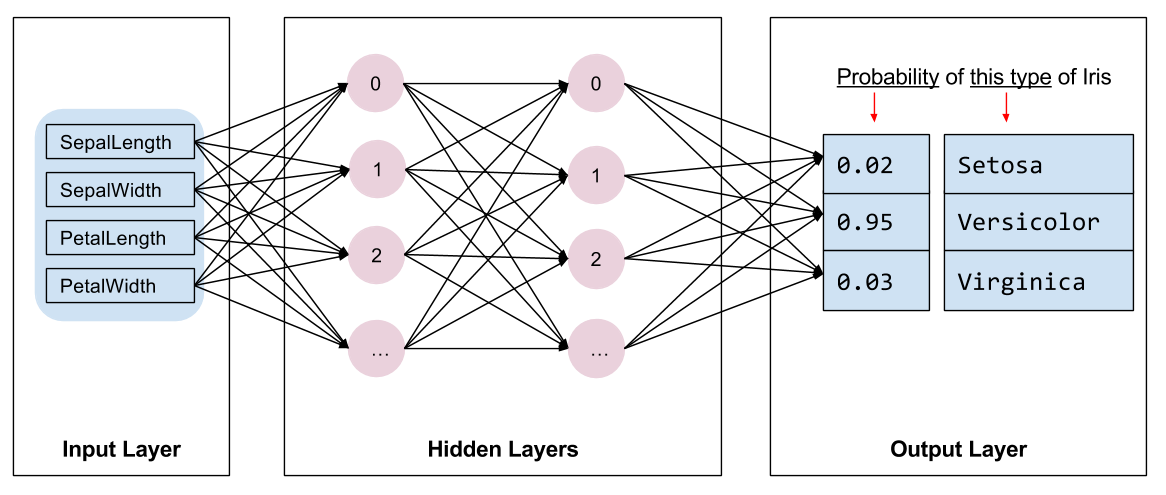

# Creando el modelo con Keras
La API de TensorFlow con Keras simplifica mucho la creación del modelo y la experimentación con el mismo. Dado que tenemos 4 atributos tenemos una capa de entrada con 4 nodos (neuronas), las dos capas intermedias tendrán 10 nodos y la última capa tiene 3 nodos, los cuales representan cada categoría.

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(3)
])

La función de activación representa cual es el output de una neurona hacia la siguiente capa y existen muchas (https://www.tensorflow.org/api_docs/python/tf/keras/activations), pero ReLU es comúnmente usada para capaz ocultas. El número de neuronas o nodos en las capaz intermedias requiere mucha experimentación, pero el incrementar mucho el número de capaz y neuronas crea un modelo en general que es más poderoso pero requiere de muchos datos para ser entrenado de forma efectiva (sin overfitting)

# Definiendo la funcion de error y el gradiente.
El entrenamiento y evaluación requieren de una función de error. Esta mide cuan alejadas están las predicciones que el modelo está haciendo con las etiquetas reales, en otras palabras cuan mal están lo está haciendo el modelo y por supuesto nosotros queremos minimizar este error. Nuestro modelo calculara este error usando **tf.losses.sparse_softmax_cross_entropy**.

In [ ]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, model.variables)

# Creando el optimizador

Un optimizador aplica los gradientes calculados para un punto y se mueve en la dirección en donde la función decrece más fuertemente, que es justamente la opuesta al gradiente.
TensorFlow tiene muchos algoritmos de optimización (https://www.tensorflow.org/api_guides/python/train) disponibles para entrenar. Para este caso particular usaremos **tf.train.GradientDescentOptimizer** el cual implementa un **stochastic gradient descent (SGD)**. El parámetro **learning_rate** fija el tamaño del paso (step size) que el algoritmo da en cada iteración.


In [ ]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

# Loop de entrenamiento
Con todas las piezas listas estamos listos para entrenar. El procedimiento para entrenar es el siguiente

    1) Iterar en cada época. Una época es considerada una cuando visitamos todo el data set.
    2) Dentro de una época itera sobre capa iteramos sobre cada ejemplo en el data set tomando sus atributos (x) y etiquetas (y).
    3) Usando los atributos de cada ejemplo, hacemos una predicción y la comparamos con la etiqueta real, lo cual nos permite medir cuan mal lo estamos haciendo, calculando así el error y con esto los gradientes.
    4) Usamos un optimizador para ajustar las variables del modelo.
    5) Hacemos un seguimiento de algunos valores para visualización.
    6) Repetimos para cada época.

El número de épocas controla el número de veces que recorremos todo el set de datos. Contra-intuitivamente el aumentar este número no garantiza un mejor desempeño del modelo.


In [ ]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy() 

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())

    # Track progress
    epoch_loss_avg(loss(model, x, y))  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)
    
  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
    
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

# Fijando los datos de testeo.
Evaluar el modelo es muy similar a entrenarlo, la mayor diferencia es que los ejemplos nunca fueron usados en el entrenamiento. 

In [ ]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)             # skip header row
test_dataset = test_dataset.map(parse_csv)      # parse each row with the funcition created earlier
test_dataset = test_dataset.shuffle(1000)       # randomize
test_dataset = test_dataset.batch(32)

test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

# Evaluando en un nuevo dataset.

In [ ]:
class_ids = ["Iris setosa", "Iris versicolor", "Iris virginica"]

predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  name = class_ids[class_idx]
  print("Example {} prediction: {}".format(i, name))